<a href="https://colab.research.google.com/github/arthiv21/PBMC_Classifier/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import math
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text


This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/labels.csv")
counts_pd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_counts.csv")

In [ ]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type, shuffle your data, split into train and test sets (80:20 split)

In [ ]:
categories = df['bulk_labels'].unique()       # original code had df['cell type'], but 'cell type' isn't a column name

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

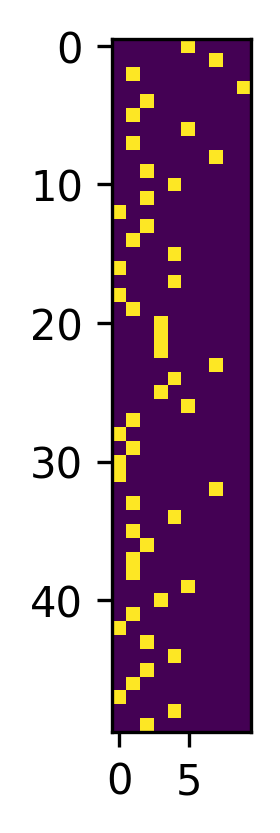

In [ ]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data, and evaluate on test data.

In [ ]:
# Training loop

def train(model, X_train, y_train, X_val, y_val, epochs=15, batch_size=32, lr=1e-3):
    """
    Inputs
    - model: the model to be trained - a PyTorch nn.Module class object
    - X_train, y_train, X_val, y_val: training and validation data
    - epochs: num epochs, or the number of times we want to run through the entire training data
    - batch_size: number of data points per batch
    - lr: learning rate
    - optimizer: optimizer used

    Outputs
    - losses: a list of losses
    - accuracies: a list of validation accuracies
    - train_accs: a list of training accuracies
    """

    batches = math.ceil(len(X_train) / batch_size)   # using batch_size, determine the number of batches needed

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    train_accs = []
    accuracies = []

    y_train = np.argmax(y_train, axis=1)               # y_train is one hot encoded, use np.argmax to convert it to the label form
    y_val = np.argmax(y_val, axis=1)               # y_val is one hot encoded, use np.argmax to convert it to the label form

    for epoch in range(epochs):
        for i in range(batches):
            X_batch = torch.tensor(X_train[i*batch_size:i*batch_size + batch_size], dtype=torch.float32)
            y_batch = torch.tensor(y_train[i*batch_size:i*batch_size + batch_size])

            logits = model(X_batch)

            loss = loss_fn(logits, y_batch)

            # these 3 functions will follow you whenever you train a model with PyTorch
            optimizer.zero_grad()   # erases the gradients from the previous epoch (sets all gradients to 0)
            loss.backward()         # calculates the gradients with respect to every single weight matrix in the model
            optimizer.step()        # takes ONE learning step with the gradients just calculated


        # calculate the training accuracy
        y_pred_train = model.classify(X_train).numpy()

        acc_score = accuracy_score(y_pred_train, y_train)
        train_accs.append(acc_score)

        # calculate the validation accuracy and append the loss of this epoch
        y_pred_val = model.classify(X_val)
        accuracy = accuracy_score(y_pred_val, y_val)
        accuracies.append(accuracy)
        losses.append(loss)

        # print epoch, loss, and current test accuracy
        print(f"Epoch {epoch}:\tloss {loss} & accuracy {accuracy}")

    return losses, accuracies, train_accs

In [ ]:
# Feed forward neural network

class My_Network(nn.Module):
    def __init__(self, num_layers, hidden_size, input_feature_dim):
        super().__init__()
        self.num_layers = num_layers
        self.input_layer = nn.Linear(input_feature_dim, hidden_size)         # (number of features, arbitrary number of neurons in )
        self.hidden_layer_A = nn.Linear(hidden_size, hidden_size)        # (number of neurons in input layer, number of neurons in hidden layer)
        self.hidden_layer_B = nn.BatchNorm1d(hidden_size)       # normalizes the data between hidden layers
        self.hidden_layer_C = nn.ReLU()
        self.hidden_layer_D = nn.Dropout(p=0.3)
        self.output_layer = nn.Linear(hidden_size, 10)          # (number of neurons in hidden layer, number of classes)

    def forward(self, X):
        X = self.input_layer(X)
        X = self.hidden_layer_D(X)
        X = self.hidden_layer_A(X)
        X = self.hidden_layer_C(X)

        logits = self.output_layer(X)
        return logits

    def classify(self, X):
        X = torch.tensor(X).type(torch.float32)     # enforce smooth-running with the model
        logits = self(X)

        prob = F.softmax(logits, dim=1)      # dim=1 allows softmax to be applied to a row (aka an individual sample)
        labels = torch.argmax(prob, dim=1)
        return labels.type(torch.long)


# Instantiate and train the feed forward neural network
my_model = My_Network(6, 256, X_train.shape[1])      # X_train.shape[1] gives the number of input features
losses, accuracies, train_accs = train(my_model, X_train, y_train, X_test, y_test, epochs=5)

Epoch 0:	loss 0.8981257081031799 & accuracy 0.7642857142857142
Epoch 1:	loss 0.2190985232591629 & accuracy 0.8428571428571429
Epoch 2:	loss 0.04254421591758728 & accuracy 0.8285714285714286
Epoch 3:	loss 0.016145730391144753 & accuracy 0.8642857142857143
Epoch 4:	loss 0.006508371327072382 & accuracy 0.8928571428571429


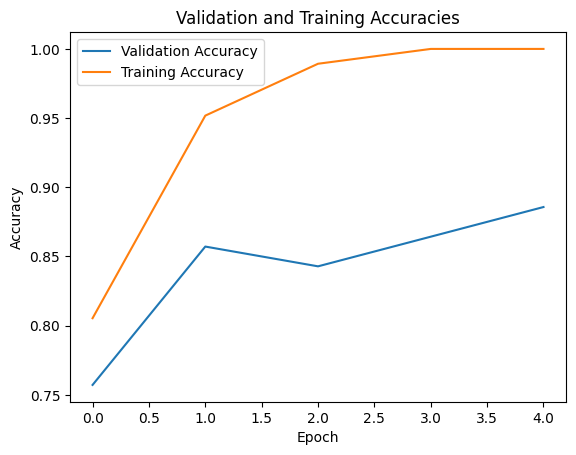

In [ ]:
# Graph the feed forward neural network
def graph(accuracies, training_accs):
    """
    Inputs
    - accuracies: list of floats with length epochs
    - training_accs: list of floats with length epochs

    Outputs
    - None
    """
    plt.plot(accuracies, label = "Validation Accuracy")
    plt.plot(training_accs, label = "Training Accuracy")

    plt.title("Validation and Training Accuracies")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

graph(accuracies, train_accs)

In [ ]:
# Random forests

# random forest model creation
rfc = RandomForestClassifier(n_estimators=80, criterion='entropy')
rfc.fit(X_train, y_train)

# predictions on the test data
y_pred = rfc.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.6214285714285714


In [ ]:
# Decision tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# decision tree model creation
dtc = DecisionTreeClassifier(max_depth=5, random_state = 42)
dtc.fit(X_train, y_train)

# predictions on the test data
y_pred = dtc.predict(X_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.7


In [ ]:
# Visualize the tree
tree_rules = export_text(dtc, feature_names = list(df.columns.drop('bulk_labels')))
print(tree_rules)


|--- CST3 <= -0.72
|   |--- CD79A <= 0.23
|   |   |--- NKG7 <= 0.09
|   |   |   |--- CD8B <= 0.97
|   |   |   |   |--- CD52 <= -0.60
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- CD52 >  -0.60
|   |   |   |   |   |--- class: 1
|   |   |   |--- CD8B >  0.97
|   |   |   |   |--- UBE2F <= 0.03
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- UBE2F >  0.03
|   |   |   |   |   |--- class: 0
|   |   |--- NKG7 >  0.09
|   |   |   |--- NKG7 <= 2.39
|   |   |   |   |--- CCNI <= 0.74
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- CCNI >  0.74
|   |   |   |   |   |--- class: 0
|   |   |   |--- NKG7 >  2.39
|   |   |   |   |--- CD7 <= 0.64
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- CD7 >  0.64
|   |   |   |   |   |--- class: 0
|   |--- CD79A >  0.23
|   |   |--- IL32 <= -0.03
|   |   |   |--- GZMK <= 1.26
|   |   |   |   |--- class: 0
|   |   |   |--- GZMK >  1.26
|   |   |   |   |--- ARL6IP5 <= -0.46
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ARL6IP5